In [94]:
import csv 

import numpy as np
import scopesim as sim
import synphot
from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.table import Table
from scipy import optimize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Make test PSFs

In [95]:
def make_psf_fits(psf, pix_size, wlen, pix_center):
    primary_hdr = fits.Header()
    primary_hdr["FILETYPE"] = 'Point Spread Function'
    primary_hdr["AUTHOR"] = 'J. Aveiro'
    primary_hdr["DATE"] = '2023'
    primary_hdr["SOURCE"] = 'TEST'
    primary_hdr["ORIGDATE"] = '2023'
    primary_hdr["WAVELENG"] = (wlen, "microns")
    primary_hdr["PIXSIZE"] = (pix_size, "milliarcsec")
    primary_hdr["XPOSITIO"] = (0.00000, "arcsec")
    primary_hdr["YPOSITIO"] = (0.00000, "arcsec")

    image_hdr = fits.Header()
    image_hdr["WAVELENG"] = (wlen, "microns")
    image_hdr["PIXSIZE"] = (pix_size, "milliarcsec")
    image_hdr["PIXSCALE"] = (pix_size, "milliarcsec")
    image_hdr["CDELT1"] = (pix_size, "[mas] Coordinate increment at reference point")
    image_hdr["CDELT2"] = (pix_size, "[mas] Coordinate increment at reference point")
    image_hdr["CTYPE1"] = ("LINEAR", "Coordinate type code")
    image_hdr["CTYPE2"] = ("LINEAR", "Coordinate type code")
    image_hdr["CUNIT1"] = ("mas", "Units of coordinate increment and value")
    image_hdr["CUNIT2"] = ("mas", "Units of coordinate increment and value")
    image_hdr["CRVAL1"] = (0.0, "[mas] Coordinate value at reference point")
    image_hdr["CRVAL2"] = (0.0, "[mas] Coordinate value at reference point")
    image_hdr["CRPIX1"] = (pix_center, "Pixel coordinate of reference point")
    image_hdr["CRPIX2"] = (pix_center, "Pixel coordinate of reference point")

    primary_hdu = fits.PrimaryHDU(header=primary_hdr)
    image_hdu = fits.ImageHDU(psf, header=image_hdr)
    hdul = fits.HDUList([primary_hdu, image_hdu])

    return hdul

In [96]:
def make_gaussian_psf(pix_size, filename):
    wlen = 3.7875 # L' band

    fwhm = (wlen * 1e-6 / 39) / 4.8481368E-9 / pix_size
    sigma_to_fwhm = 2 * np.sqrt(2 * np.log(2))
    psf_stddev = fwhm / sigma_to_fwhm

    psf_size = 128
    psf = Gaussian2DKernel(x_stddev=psf_stddev,
                           y_stddev=psf_stddev,
                           x_size=psf_size,
                           y_size=psf_size).array
    psf = np.array(psf)
    psf = psf/np.sum(psf)
    pix_center = psf_size // 2
    hdul = make_psf_fits(psf, pix_size, wlen, pix_center)
    hdul.writeto(filename, overwrite=True)

In [97]:
make_gaussian_psf(pix_size=5.47, filename="gaussian_psf_pix_5.47mas_size_128.fits") # METIS pixel scale
make_gaussian_psf(pix_size=6.88, filename="gaussian_psf_pix_6.88mas_size_128.fits") # COMPASS SIM PSF pixel scale

# Helpers

In [98]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)


In [99]:
def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

In [100]:
def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

# Test

To test the effect of resampling (rescaling) the PSF, run the simulation without noise and background for a single point source near the centre of the field, and fit the PSF model (Gaussian) to resulting image. This is repeated for several subpixel positions. Then, the FWHM and centroid estimation errors can be analysed.

In [101]:
# sim.download_packages(["Armazones", "ELT", "METIS"])
local_packages = "./inst_pkgs"
sim.rc.__config__["!SIM.file.local_packages_path"] = local_packages

In [102]:
def run(psf_file, spline_order, case):
    # Setup
    cmd = sim.UserCommands(use_instrument='METIS', set_modes=['img_lm'])
    cmd["OBS"]["psf_file"] = psf_file
    cmd["!SIM.computing.spline_order"] = spline_order
    metis = sim.OpticalTrain(cmd)
    
    # Remove all unnecessary effects and reduce simulation to convolution of point sources with PSF
    metis["auto_exposure"].include = False
    metis.cmds["!OBS.detector_readout_mode"] = "fast"
    metis.cmds["!SIM.sub_pixel.flag"] = True

    effects_toremove = ["cold_stop", "quantum_efficiency", "dark_current", "shot_noise", "readout_noise",
                        "detector_linearity", "skycalc_atmosphere", "auto_exposure", "telescope_reflection",
                        "common_fore_optics", "img_lm_optics", "adc_wheel"]

    for effect_name in effects_toremove:
        metis[effect_name].include = False
    metis.update()

    # Run test for different subpixel positions
    dit = 1
    ndit = 1
    # xc_list = np.concatenate([np.arange(0, 1, 0.05), np.zeros_like(np.arange(0, 1, 0.05))])
    # yc_list = np.concatenate([np.zeros_like(np.arange(0, 1, 0.05)), np.arange(0, 1, 0.05)])
    xc_list = np.arange(0, 1, 0.05)
    yc_list = xc_list.copy()
    pixel_size = 5.47e-3

    with open(f"results_fit_{case}.csv", "w", newline="") as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(["height", "x", "y", "width_x", "width_y", "fwhm_x", "fwhm_y", "dx", "dy", "sum"])

    for xc, yc in tqdm(zip(xc_list, yc_list), total=len(xc_list)):
        
        # Define single source
        vega = synphot.spectrum.SourceSpectrum.from_vega()
        mag = 16
        weight = 10 ** (-0.4 * mag)
        obj = Table(names=["x", "y", "ref", "weight"],
                    data=[[xc * pixel_size], [yc * pixel_size], [0], [weight]],
                    units=[u.arcsec, u.arcsec, None, None])
        src = sim.Source(table=obj, spectra=[vega])

        # Observe
        metis.observe(src, update=True)
        img = metis.readout(exptime=dit)[0][1].data
        
        # Fit gaussian to image
        params = fitgaussian(img) # (height, x, y, width_x, width_y)
        height, x, y, width_x, width_y = params
        std2fwhm = 2*np.sqrt(2*np.log(2))
        fwhm_x = width_x * std2fwhm
        fwhm_y = width_y * std2fwhm
        line = *params, fwhm_x, fwhm_y, xc, yc, np.sum(img)

        with open(f"results_fit_{case}.csv", "a", newline="") as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(line)

## Run Tests

### Direct (no resampling)

In [103]:
run("gaussian_psf_pix_5.47mas_size_128.fits", spline_order=1, case="direct")

  0%|          | 0/20 [00:00<?, ?it/s]

### Resampled (spline_order=1)

In [104]:
run("gaussian_psf_pix_6.88mas_size_128.fits", spline_order=1, case="rescal_order_1")

  0%|          | 0/20 [00:00<?, ?it/s]

### Resampled (spline_order=2)

In [105]:
run("gaussian_psf_pix_6.88mas_size_128.fits", spline_order=2, case="rescal_order_2")

  0%|          | 0/20 [00:00<?, ?it/s]

### Resampled (spline_order=3)

In [106]:
run("gaussian_psf_pix_6.88mas_size_128.fits", spline_order=3, case="rescal_order_3")

  0%|          | 0/20 [00:00<?, ?it/s]

# Results

In [107]:
df_direct = pd.read_csv("results_fit_direct.csv")
df_rescal_order_1 = pd.read_csv("results_fit_rescal_order_1.csv")
df_rescal_order_2 = pd.read_csv("results_fit_rescal_order_2.csv")
df_rescal_order_3 = pd.read_csv("results_fit_rescal_order_3.csv")

### Testing FWHM error

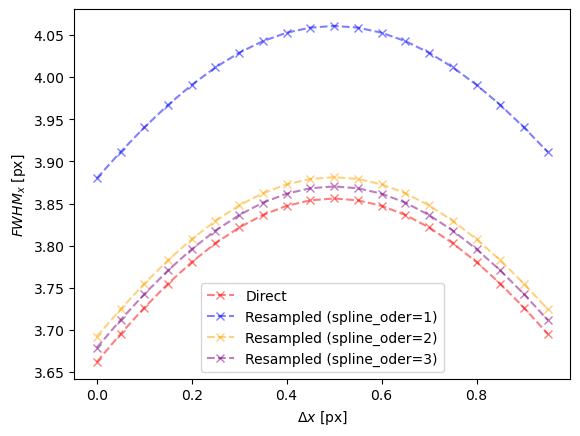

In [108]:
opts = {"marker": 'x',
        "linestyle": 'dashed',
        "alpha": 0.5}

plt.plot(df_direct["dx"], df_direct["fwhm_x"], c="red", label="Direct", **opts)
plt.plot(df_rescal_order_1["dx"], df_rescal_order_1["fwhm_x"], c="blue", label="Resampled (spline_oder=1)", **opts)
plt.plot(df_rescal_order_2["dx"], df_rescal_order_2["fwhm_x"], c="orange", label="Resampled (spline_oder=2)", **opts)
plt.plot(df_rescal_order_3["dx"], df_rescal_order_3["fwhm_x"], c="purple", label="Resampled (spline_oder=3)", **opts)
plt.xlabel(r"$\Delta x$ [px]")
plt.ylabel(r"$FWHM_x$ [px]")
plt.legend()
plt.show()

__Comments:__ With spline_order=1 the FWHM error is almost 10%. This is greatly reduced by choosing spline_order=2 and slightly improved for spline_order=3.

### Testing centroid error

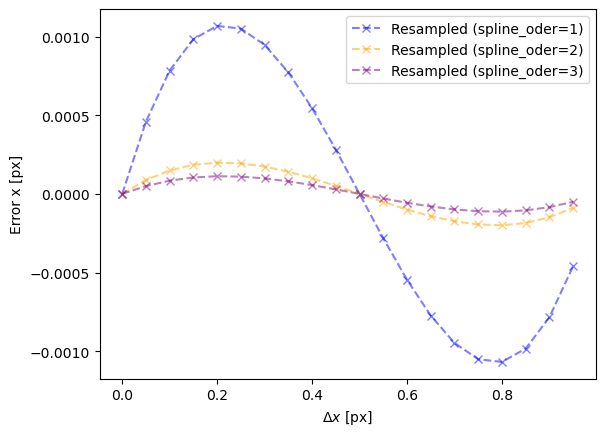

In [109]:
opts = {"marker": 'x',
        "linestyle": 'dashed',
        "alpha": 0.5}

plt.plot(df_rescal_order_1["dx"], df_rescal_order_1["x"] - df_direct["x"] + 0.5, c="blue", label="Resampled (spline_oder=1)", **opts)
plt.plot(df_rescal_order_2["dx"], df_rescal_order_2["x"] - df_direct["x"] + 0.5, c="orange", label="Resampled (spline_oder=2)", **opts)
plt.plot(df_rescal_order_3["dx"], df_rescal_order_3["x"] - df_direct["x"] + 0.5, c="purple", label="Resampled (spline_oder=3)", **opts)
plt.xlabel(r"$\Delta x$ [px]")
plt.ylabel(r"Error x [px]")
plt.legend()
plt.show()

__Comments:__ With spline_order=1 the maximum centroid error is approx. 1e-3 px. For the METIS pixel scale (5.47 mas), this corresponds to a few uas, which is appreciable for high precision astrometry (<100 uas). This is greatly reduced by choosing higher order splines to  <1 uas.